## Analysis of google reviews

In [710]:
import pandas as pd
import pickle
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

## import data and drop columns

In [711]:
df = pd.read_csv("../raw_data/reviews_clean_1_12.csv")

In [712]:
df.drop(columns=["index","Unnamed: 0", "comment_names"], inplace=True)
df.shape

(48421, 4)

In [713]:
df.drop_duplicates(inplace=True)

df.head()

,restaurant_name,comment_ratings,comment_dates,comment_comments
0,Augusto Lisboa,Rated 5.0 out of 5.,2 weeks ago,Well worth the small wait to get in of around ...
1,Augusto Lisboa,Rated 5.0 out of 5.,5 days ago,Two words: Homemade excellence. This place set...
2,Augusto Lisboa,Rated 5.0 out of 5.,6 days ago,"Chic vibe, excellent service, and delicious fo..."
3,Augusto Lisboa,Rated 5.0 out of 5.,2 weeks ago,Some of the best brunch I’ve had! Cheery and c...
4,Augusto Lisboa,Rated 4.0 out of 5.,a week ago,Love the avocado toast! Best cappuccino and th...


In [714]:
df.shape

(48421, 4)

In [715]:
cleaned_df = df.dropna()
cleaned_df = cleaned_df.reset_index(drop=True)
cleaned_df.shape

(48313, 4)

### Clean score column

In [716]:
cleaned_df.comment_ratings.unique()

array(['Rated 5.0 out of 5.', 'Rated 4.0 out of 5.',
       'Rated 1.0 out of 5.', 'Rated 3.0 out of 5.',
       'Rated 2.0 out of 5.'], dtype=object)

In [717]:
def extract_score(series):
    return float(series[6:9])

In [718]:
cleaned_df['comment_ratings'] = cleaned_df['comment_ratings'].apply(extract_score)

In [719]:
cleaned_df.comment_ratings.unique()

array([5., 4., 1., 3., 2.])

In [720]:
cleaned_df.dtypes

restaurant_name      object
comment_ratings     float64
comment_dates        object
comment_comments     object
dtype: object

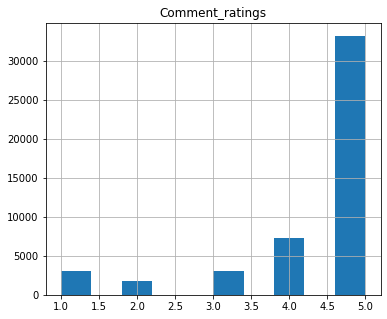

In [721]:
plt.figure(figsize=(6,5))
plt.title("Comment_ratings")
plt.grid()
plt.hist(cleaned_df.comment_ratings);

### Clean comment dates column

In [722]:
cleaned_df.comment_dates.unique()

array(['2 weeks ago', '5 days ago', '6 days ago', 'a week ago',
       '3 weeks ago', '2 months ago', 'a month ago', '2 days ago',
       '3 months ago', '5 months ago', '3 days ago', '6 months ago',
       '4 months ago', 'a year ago', '4 days ago', '2 years ago',
       '11 months ago', '4 years ago', '10 months ago', '7 months ago',
       '8 months ago', '4 weeks ago', '3 years ago', '5 years ago',
       '9 years ago', '8 years ago', 'a day ago', '6 years ago',
       '9 months ago', '10 years ago', '15 hours ago', '35 minutes ago',
       '14 hours ago', '7 years ago', '11 years ago', '16 hours ago',
       '23 hours ago', '4 hours ago', '3 hours ago', '17 hours ago',
       '19 hours ago', '22 hours ago', '11 hours ago', '6 hours ago',
       '46 minutes ago', '2 hours ago', '7 hours ago', '5 hours ago'],
      dtype=object)

In [723]:
cleaned_df.comment_dates

0        2 weeks ago
1         5 days ago
2         6 days ago
3        2 weeks ago
4         a week ago
            ...     
48308    3 years ago
48309    2 years ago
48310    2 years ago
48311    3 years ago
48312    5 years ago
Name: comment_dates, Length: 48313, dtype: object

In [724]:
def clean_comment_dates(text):
    text = text.replace("ago","")
    text = text.replace("s","")
    text = text.replace(" day","*1")
    text = text.replace(" week","*7")
    text = text.replace(" month","*30")
    text = text.replace(" year","*365")
    if "minute" in text or  "hour" in text:
        text = "1"
    if "a" in text:
        text = text.replace("a", "1")
    return eval(text)

In [725]:
cleaned_df.comment_dates = cleaned_df.comment_dates.apply(clean_comment_dates)

In [726]:
cleaned_df.rename(columns={'comment_dates':'when_written_days_ago'}, inplace=True)

In [780]:
def contains_portuguese(text):
    if "traduzido" in text.lower():
        return 1
    else:
        return 0

In [781]:
cleaned_df['contains_portuguese']=cleaned_df.comment_comments.apply(contains_portuguese)

In [786]:
cleaned_df[cleaned_df.contains_portuguese == 1].iloc[0,3]

'(Traduzido pelo Google) Tivemos a oportunidade de comer neste restaurante familiar com as minhas filhas de 9 anos. Todo mundo adorou. O serviço foi ótimo. Eu recomendo …Mais'

In [730]:
cleaned_df.head()

,restaurant_name,comment_ratings,when_written_days_ago,comment_comments,contains_portuguese
0,Augusto Lisboa,5.0,14,Well worth the small wait to get in of around ...,0
1,Augusto Lisboa,5.0,5,Two words: Homemade excellence. This place set...,0
2,Augusto Lisboa,5.0,6,"Chic vibe, excellent service, and delicious fo...",0
3,Augusto Lisboa,5.0,14,Some of the best brunch I’ve had! Cheery and c...,0
4,Augusto Lisboa,4.0,7,Love the avocado toast! Best cappuccino and th...,0


In [618]:
cleaned_df.to_csv("cleaned_df_reviews.csv")

### Clean Reviews

In [731]:
cleaned_df.comment_comments.tail()

48308    (Translated by Google) Food very well\n\n(Orig...
48309    (Translated by Google) Good quality of product...
48310    (Translated by Google) It's good.\n\n(Original...
48311    (Translated by Google) Very good and I will al...
48312    (Translated by Google) Service good and fast. ...
Name: comment_comments, dtype: object

In [732]:
def remove_google_trans_comment(series):
    if "(Translated by Google)" in series:
        return series.replace("(Translated by Google) ","")
    else:
        return series    

In [733]:
def remove_original_translation(series):
    if "\n\n(Original)" in series:
        index = series.find("\n\n(Original)")
        return series[:index]
    else:
        return series    

In [734]:
cleaned_df.comment_comments = cleaned_df.comment_comments.apply(remove_google_trans_comment)

In [735]:
cleaned_df.comment_comments = cleaned_df.comment_comments.apply(remove_original_translation)

In [736]:
cleaned_df.comment_comments.tail()

48308                           Food very well
48309                 Good quality of products
48310                               It's good.
48311    Very good and I will always come back
48312      Service good and fast. Tasty Pizzas
Name: comment_comments, dtype: object

In [737]:
cleaned_df.shape

(48313, 5)

## DataFrame Selection

### Importing restaurants

In [738]:
df_restaurants = pd.read_csv("../raw_data/Clean_data_1_12_v2.csv")

In [739]:
df_restaurants.head()

,Unnamed: 0,name,type,description,rating,review_count,price,address,label,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood
0,0,Augusto Lisboa,brunch,"Hip brunch eatery serving savory toasts, banan...",4.8,1032.0,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",1,1,0,0,1,0,1100-491,Lisboa,Graça
1,1,Tiffin Cafe & Restaurant Lisboa,brunch,NaN,4.9,139.0,2.0,"R. do Conde 32, 1200-637 Lisboa, Portugal","['dine-in', 'takeaway', 'delivery']",1,1,1,0,0,0,1200-637,Lisboa,Prazeres
2,2,Crisfama,restaurant,NaN,4.8,649.0,1.0,"Rua da Cruz de Santa Apolónia 56, 1100-188 Lis...","['dine-in', 'takeaway', 'no delivery']",1,1,0,0,1,0,1100-188,Lisboa,Santa Engrácia
3,3,Alma,fine dining,High-end restaurant with avant-garde local mea...,4.8,953.0,4.0,"R. Anchieta 15, 1200-224 Lisboa, Portugal","['dine-in', 'no takeaway', 'no delivery']",1,1,0,0,1,0,1200-224,Lisboa,São Paulo
4,4,Restaurant CHULHO & Bar,restaurant,NaN,4.9,180.0,NaN,"R. de São João da Mata 82, 1200-850 Lisboa, Po...","['dine-in', 'takeaway', 'delivery']",1,1,1,0,0,0,1200-850,Lisboa,Lapa


In [740]:
df_restaurants.drop(columns=["Unnamed: 0", "rating"], inplace=True)

In [741]:
df_restaurants.rename(columns={'name':'restaurant_name', 'type':'restaurant_type'}, inplace=True)

In [742]:
df_restaurants.head()

,restaurant_name,restaurant_type,description,review_count,price,address,label,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood
0,Augusto Lisboa,brunch,"Hip brunch eatery serving savory toasts, banan...",1032.0,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",1,1,0,0,1,0,1100-491,Lisboa,Graça
1,Tiffin Cafe & Restaurant Lisboa,brunch,NaN,139.0,2.0,"R. do Conde 32, 1200-637 Lisboa, Portugal","['dine-in', 'takeaway', 'delivery']",1,1,1,0,0,0,1200-637,Lisboa,Prazeres
2,Crisfama,restaurant,NaN,649.0,1.0,"Rua da Cruz de Santa Apolónia 56, 1100-188 Lis...","['dine-in', 'takeaway', 'no delivery']",1,1,0,0,1,0,1100-188,Lisboa,Santa Engrácia
3,Alma,fine dining,High-end restaurant with avant-garde local mea...,953.0,4.0,"R. Anchieta 15, 1200-224 Lisboa, Portugal","['dine-in', 'no takeaway', 'no delivery']",1,1,0,0,1,0,1200-224,Lisboa,São Paulo
4,Restaurant CHULHO & Bar,restaurant,NaN,180.0,NaN,"R. de São João da Mata 82, 1200-850 Lisboa, Po...","['dine-in', 'takeaway', 'delivery']",1,1,1,0,0,0,1200-850,Lisboa,Lapa


In [743]:
df_restaurants.shape

(585, 16)

In [744]:
df_restaurants.price.isna().sum()

233

### Merging dfs

In [745]:
merged_df = cleaned_df.merge(df_restaurants, on="restaurant_name", how="left")
merged_df.head(1)

,restaurant_name,comment_ratings,when_written_days_ago,comment_comments,contains_portuguese,restaurant_type,description,review_count,price,address,label,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood
0,Augusto Lisboa,5.0,14,Well worth the small wait to get in of around ...,0,brunch,"Hip brunch eatery serving savory toasts, banan...",1032.0,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",1.0,1.0,0.0,0.0,1.0,0.0,1100-491,Lisboa,Graça


In [746]:
merged_df.shape

(48313, 20)

In [747]:
merged_df.dtypes

restaurant_name           object
comment_ratings          float64
when_written_days_ago      int64
comment_comments          object
contains_portuguese        int64
restaurant_type           object
description               object
review_count             float64
price                    float64
address                   object
label                     object
dine_in                  float64
takeaway                 float64
delivery                 float64
drive_through            float64
no_del_exp               float64
curb_pickup              float64
postal_code               object
municipality              object
neighborhood              object
dtype: object

In [ ]:
filtering by 

## filtering merged dataset

In [748]:
restaurant_type = 'brunch '
price = 2.0
neighborhood = 'Graça'
min_rating = 0.0
max_rating = 3.0

In [749]:
filtered_df = merged_df
#filtered_df = filtered_df[filtered_df['restaurant_type'] == restaurant_type]
# filtered_df = filtered_df[filtered_df['price'] == price]
# filtered_df = filtered_df[filtered_df['neighborhood'] == neighborhood]
filtered_df = filtered_df[filtered_df['comment_ratings'] >= min_rating]
filtered_df = filtered_df[filtered_df['comment_ratings'] <= max_rating]

# filtered_df = filtered_df[filtered_df['dine_in'] == 1]
# filtered_df = filtered_df[filtered_df['takeaway'] == 1]
# filtered_df = filtered_df[filtered_df['delivery'] == 1]
# filtered_df = filtered_df[filtered_df['drive_through'] == 1]
# filtered_df = filtered_df[filtered_df['no_del_exp'] == 1]
# filtered_df = filtered_df[filtered_df['curb_pickup'] == 1]

In [750]:
filtered_df.head()

,restaurant_name,comment_ratings,when_written_days_ago,comment_comments,contains_portuguese,restaurant_type,description,review_count,price,address,label,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood
40,Augusto Lisboa,1.0,14,"Proper food, but please create a proper queue....",0,brunch,"Hip brunch eatery serving savory toasts, banan...",1032.0,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",1.0,1.0,0.0,0.0,1.0,0.0,1100-491,Lisboa,Graça
50,Augusto Lisboa,3.0,30,"It was ok. Surprised the ratings were so high,...",0,brunch,"Hip brunch eatery serving savory toasts, banan...",1032.0,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",1.0,1.0,0.0,0.0,1.0,0.0,1100-491,Lisboa,Graça
58,Augusto Lisboa,3.0,60,The waitress who seated us was very nice but t...,0,brunch,"Hip brunch eatery serving savory toasts, banan...",1032.0,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal","['dine-in', 'takeaway', 'no delivery']",1.0,1.0,0.0,0.0,1.0,0.0,1100-491,Lisboa,Graça
244,Crisfama,1.0,365,Big disappointment. The steak I ordered was ra...,0,restaurant,NaN,649.0,1.0,"Rua da Cruz de Santa Apolónia 56, 1100-188 Lis...","['dine-in', 'takeaway', 'no delivery']",1.0,1.0,0.0,0.0,1.0,0.0,1100-188,Lisboa,Santa Engrácia
257,Crisfama,2.0,1460,Amazing food... but we were not treated well b...,0,restaurant,NaN,649.0,1.0,"Rua da Cruz de Santa Apolónia 56, 1100-188 Lis...","['dine-in', 'takeaway', 'no delivery']",1.0,1.0,0.0,0.0,1.0,0.0,1100-188,Lisboa,Santa Engrácia


## NLP preproc

In [751]:
def clean(text, list_form=False):
    """clean's text for NLP. If list_form set to False returns string otherwise returns list, by default set to False"""
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
        
    lowercased = text.lower() # Lower Case
    
    #unaccented_string = unidecode.unidecode(lowercased) # remove accents
    
    tokenized = word_tokenize(lowercased) # Tokenize
    
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    
    stop_words = set(stopwords.words('english')) # Make stopword list
    
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    
    if list_form == True:
        return without_stopwords
    else:
        return " ".join(without_stopwords)

In [752]:
filtered_df['clean_comment'] = filtered_df['comment_comments'].apply(clean)

In [753]:
filtered_df.shape

(7763, 21)

In [754]:
filtered_df.head(1)

,restaurant_name,comment_ratings,when_written_days_ago,comment_comments,contains_portuguese,restaurant_type,description,review_count,price,address,...,dine_in,takeaway,delivery,drive_through,no_del_exp,curb_pickup,postal_code,municipality,neighborhood,clean_comment
40,Augusto Lisboa,1.0,14,"Proper food, but please create a proper queue....",0,brunch,"Hip brunch eatery serving savory toasts, banan...",1032.0,2.0,"Rua Santa M.nha 26, 1100-491 Lisboa, Portugal",...,1.0,1.0,0.0,0.0,1.0,0.0,1100-491,Lisboa,Graça,proper food please create proper queue inform ...


## Tfidf

In [755]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(stopwords.words('english')) # Make stopword list

# Tuned TFidfvectorizer
def Tfidf_fit(series):
    vec = TfidfVectorizer(ngram_range = (2,2), min_df=0.1, max_df=0.9).fit(series)
    return vec

def transform_create_list(series):
    vectors = Tfidf_fit(series).transform(series) # Transform text to vectors

    sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

    tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in     Tfidf_fit(series).vocabulary_.items()]  # Get the word and associated weight

    sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

    return sorted_tfidf_list[:10]

In [756]:
Tfidf_fit(filtered_df.clean_comment)
transform_create_list(filtered_df.clean_comment)

[('traduzido pelo', 569.9280656363612), ('pelo google', 569.9280656363612)]

### further processing

In [757]:
text = " ".join(review for review in filtered_df.comment_comments.astype(str))

In [758]:
token_list = clean(text, list_form=True) 

In [759]:
 from collections import Counter
import matplotlib.pyplot as plt
import wordcloud

plt.rcParams["figure.figsize"] = [16, 9]

def create_ngrams(token_list, nb_elements):
    """
    Create n-grams for list of tokens. Parameters: token_list : list of strings, nb_elements : number of elements in the n-gram
    Returns: Generator, generator of all n-grams
    """
    ngrams = zip(*[token_list[index_token:] for index_token in range(nb_elements)])
    return (" ".join(ngram) for ngram in ngrams)


def frequent_words(list_words, ngrams_number=1, number_top_words=10):
    """
    Create n-grams for list of tokens. Parameters: ngrams_number : int, number_top_words : int, output dataframe length
    Returns. DataFrame, Dataframe with the entities and their frequencies.
    """
    frequent = []
    if ngrams_number == 1:
        pass
    elif ngrams_number >= 2:
        list_words = create_ngrams(list_words, ngrams_number)
    else:
        raise ValueError("number of n-grams should be >= 1")
    counter = Counter(list_words)
    frequent = counter.most_common(number_top_words)
    return frequent


def make_word_cloud(text_or_counter, stop_words=None):
    if isinstance(text_or_counter, str):
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate(text_or_counter)
    else:
        if stop_words is not None:
            text_or_counter = Counter(word for word in text_or_counter if word not in stop_words)
        word_cloud = wordcloud.WordCloud(stopwords=stop_words).generate_from_frequencies(text_or_counter)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()


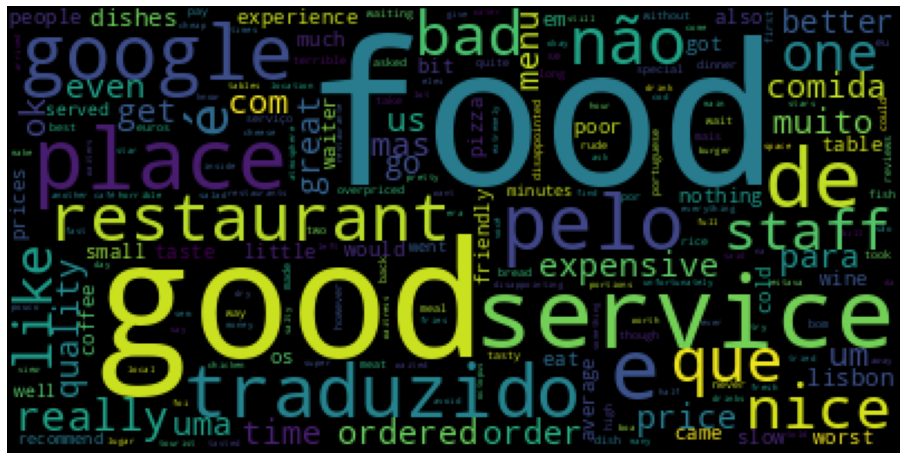

In [760]:
make_word_cloud(token_list, stop_words=stop_words)

In [761]:
frequent_words(token_list, ngrams_number=1, number_top_words=15)

[('food', 2666),
 ('good', 1767),
 ('service', 1550),
 ('place', 1075),
 ('e', 1059),
 ('de', 1022),
 ('google', 858),
 ('pelo', 852),
 ('traduzido', 806),
 ('restaurant', 779),
 ('não', 735),
 ('que', 707),
 ('nice', 669),
 ('bad', 659),
 ('é', 601)]

In [762]:
frequent_words(token_list, ngrams_number=2, number_top_words=15)

[('traduzido pelo', 806),
 ('pelo google', 806),
 ('food good', 245),
 ('good food', 139),
 ('nothing special', 110),
 ('food ok', 109),
 ('good service', 108),
 ('bad service', 102),
 ('não é', 97),
 ('service good', 91),
 ('slow service', 86),
 ('um pouco', 84),
 ('tourist trap', 78),
 ('quality food', 75),
 ('nice place', 64)]

In [763]:
frequent_words(token_list, ngrams_number=3, number_top_words=15)

[('traduzido pelo google', 806),
 ('pelo google comida', 57),
 ('pelo google não', 39),
 ('pelo google serviço', 36),
 ('food good service', 35),
 ('pelo google lugar', 29),
 ('pelo google eu', 25),
 ('pelo google um', 21),
 ('food nothing special', 19),
 ('nada de especial', 19),
 ('pelo google muito', 19),
 ('pelo google bom', 19),
 ('service good food', 18),
 ('de traduzido pelo', 18),
 ('good food good', 17)]